## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [68]:
import string
import os

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [69]:
with open("sonnets.txt", "r") as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [70]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
out = ""
max_length = 0
for line in text:
    out += line.lower()
    if len(line) > max_length:
        max_length = len(line)
text = out
print(max_length)
print(len(text))
assert len(text) == 100225, "Are you sure you have concatenated all the strings?"
assert not any([x in set(text) for x in string.ascii_uppercase]), (
    "Uppercase letters are present"
)
print("OK!")

63
100225
OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [71]:
tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [72]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {idx: token for idx, token in enumerate(tokens)}
len(tokens)

38

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [79]:
# Your code here
import torch
import torch.nn as nn
import torch.nn.functional as F

NUM_TOKENS = len(tokens)


class CharRNNLoop(nn.Module):
    def __init__(
        self,
        num_tokens: int = NUM_TOKENS,
        emb_size: int = 24,
        rnn_hidden_size: int = 64,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(
            input_size=emb_size,
            hidden_size=rnn_hidden_size,
            batch_first=True,
            num_layers=1,
        )
        self.output_layer = nn.Linear(rnn_hidden_size, num_tokens)

    def forward(
        self,
        x: torch.Tensor,
        hidden_state: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        embeddings = self.embedding(x)
        rnn_output, hidden_state = self.rnn(embeddings, hidden_state)
        logits = self.output_layer(rnn_output)
        log_probs = F.log_softmax(logits, dim=-1)
        return log_probs, hidden_state


def to_matrix(
    text: str,
    batch_size: int = 32,
    seq_len: int | None = None,
    dtype: torch.dtype = torch.long,
) -> torch.Tensor:
    if seq_len is None:
        seq_len = len(text) // batch_size

    sequences = [
        [token_to_idx[char] for char in text[start : start + seq_len]]
        for start in range(0, seq_len * batch_size, seq_len)
    ]

    return torch.tensor(sequences, dtype=dtype)


In [80]:
model = CharRNNLoop()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(model.parameters())

Plot the loss function (axis X: number of epochs, axis Y: loss function).

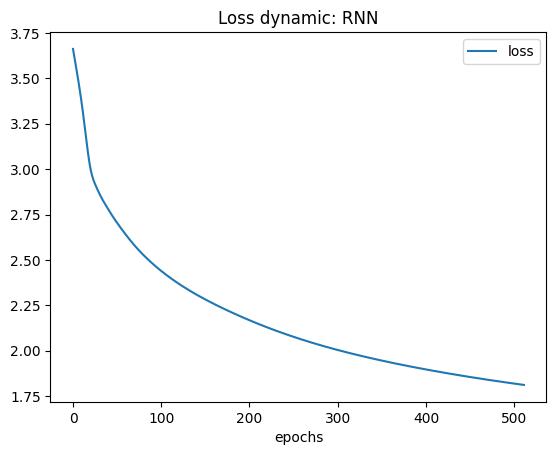

In [81]:
# Your plot code here
from IPython.display import clear_output
import torch, torch.nn as nn
import torch.nn.functional as F

batch_size = 32

batch_ix = to_matrix(text, batch_size)
history = []
for i in range(512):
    state = torch.zeros(1, batch_size, 64)
    logp_seq, _ = model(batch_ix, state)
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        logp_seq[:, :-1].contiguous().view(-1, NUM_TOKENS),
        batch_ix[:, 1:].contiguous().view(-1),
    )

    opt.zero_grad()
    loss.backward()
    opt.step()

    history.append(loss.item())

clear_output(True)
plt.plot(history, label="loss")
plt.title("Loss dynamic: RNN")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [87]:
import numpy as np
import torch
import torch.nn.functional as F


def generate_text(
    model: nn.Module,
    length: int,
    seed_phrase: str = "hell",
    temperature: float = 1.0,
) -> str:
    model.eval()

    seed_indices = [token_to_idx[token] for token in seed_phrase]
    sequence = torch.tensor([[seed_indices]], dtype=torch.long)

    hidden_state = torch.zeros(1, 1, 64)

    for idx in range(len(seed_phrase) - 1):
        _, hidden_state = model(sequence[:, :, idx], hidden_state)

    for _ in range(length - len(seed_phrase)):
        log_probs, hidden_state = model(sequence[:, :, -1], hidden_state)
        probs = F.softmax(log_probs.squeeze() / temperature, dim=-1).cpu().detach().numpy()
        next_token = np.random.choice(len(tokens), p=probs)
        next_tensor = torch.tensor([[[next_token]]], dtype=torch.long)
        sequence = torch.cat([sequence, next_tensor], dim=2)

    return "".join(tokens[idx] for idx in sequence[0, 0].tolist())


print(generate_text(model, length=500, temperature=0.5))


hell'd sich my bear,
  so hith the deand,
     and the came,
    the the and the with not whise the fark:
  thee the thou thy sand tine thy rom that still seem fat the doth whet the the shatome to mase, the bland best the heart, the suer's mene broust the rain the share but thy beaty sue see thing doth seet the sour raind,
  to that whith the prough thee has in the sine seet love hen when the live to the such so that it shore that thy peart,
  have hear my may,
  of with the the the hore thy see


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

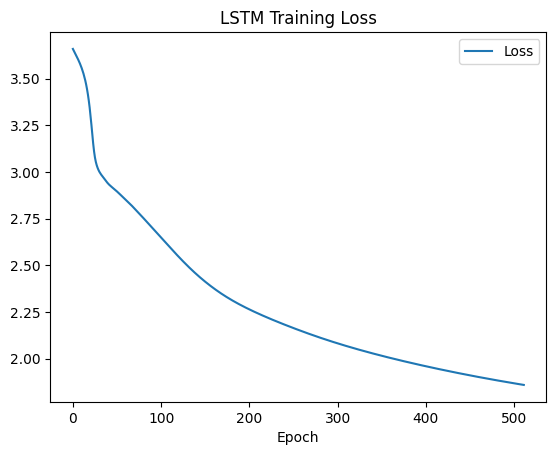

In [88]:
# Your beautiful code here
import torch
import torch.nn as nn
import torch.nn.functional as F

num_tokens = len(tokens)


class CharLSTMLoop(nn.Module):
    def __init__(
        self,
        num_tokens: int = num_tokens,
        emb_size: int = 24,
        lstm_hidden_size: int = 64,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=lstm_hidden_size,
            batch_first=True,
        )
        self.output_layer = nn.Linear(lstm_hidden_size, num_tokens)

    def forward(
        self,
        x: torch.Tensor,
        h_n: torch.Tensor,
        c_n: torch.Tensor,
    ):
        lstm_out, (h_n, c_n) = self.lstm(self.embedding(x), (h_n, c_n))
        logits = self.output_layer(lstm_out)
        log_probs = F.log_softmax(logits, dim=-1)
        return log_probs, (h_n, c_n)


model_lstm = CharLSTMLoop()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model_lstm.parameters())

num_epochs = 512
loss_history = []

for unused in range(num_epochs):
    h_init = torch.zeros(1, batch_size, 64)
    c_init = torch.zeros(1, batch_size, 64)

    log_probs, _ = model_lstm(batch_ix, h_init, c_init)

    loss = criterion(
        log_probs[:, :-1].contiguous().view(-1, num_tokens),
        batch_ix[:, 1:].contiguous().view(-1),
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())


clear_output(wait=True)
plt.plot(loss_history, label="Loss")
plt.xlabel("Epoch")
plt.title("LSTM Training Loss")
plt.legend()
plt.show()


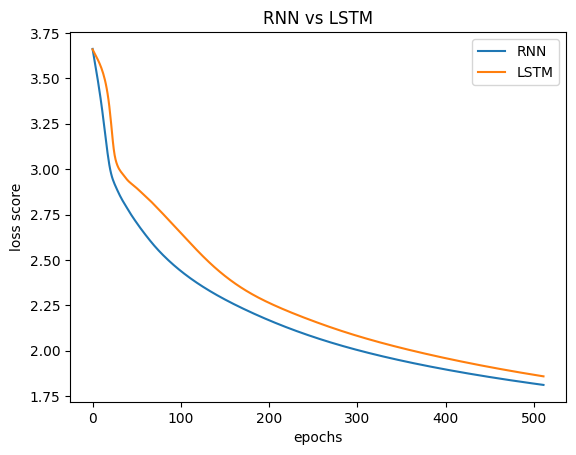

In [89]:
plt.plot(history, label="RNN")
plt.plot(loss_history, label="LSTM")
plt.title("RNN vs LSTM")
plt.xlabel("epochs")
plt.ylabel("loss score")
plt.legend()
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [95]:
# Text generation with different temperature values here
def generate_text_lstm(
    model: nn.Module,
    length: int,
    seed_phrase: str = "hell",
    temperature: float = 1.0,
) -> str:
    model.eval()

    seed_indices = [token_to_idx[token] for token in seed_phrase]
    sequence = torch.tensor([[seed_indices]], dtype=torch.long)

    h_state = torch.zeros(1, 1, 64)
    c_state = torch.zeros(1, 1, 64)

    for idx in range(len(seed_phrase) - 1):
        _, (h_state, c_state) = model(sequence[:, :, idx], h_state, c_state)

    for _ in range(length - len(seed_phrase)):
        log_probs, (h_state, c_state) = model(
            sequence[:, :, -1], h_state, c_state
        )
        probs = F.softmax(log_probs.squeeze() / temperature, dim=-1).cpu().detach().numpy()
        next_token = np.random.choice(len(tokens), p=probs)
        next_tensor = torch.tensor([[[next_token]]], dtype=torch.long)
        sequence = torch.cat([sequence, next_tensor], dim=2)

    return "".join(tokens[idx] for idx in sequence[0, 0].tolist())

In [96]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(generate_text_lstm(model_lstm, length=500, temperature=t))
    print("&" * 40)

hell, and the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
hell beare the the the the the the the the the the the sell the the the the the the the the sore the the the the the the the stell the the the me the the the the the the the the the the the sull the the the the preave the the the the the the the the the so the the the the the the the the the the the the the the the the me the the the the the the the the the the the the the the the the the the the the the the the the the the see bear in the that the the s

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [97]:
# Saving and loading code here
torch.save(model_lstm.state_dict(), "CharLSTMLoop.pt")
model = CharLSTMLoop()
model.load_state_dict(torch.load("CharLSTMLoop.pt"))
model.eval()

print(generate_text_lstm(model, length=500, temperature=0.5))

hellomy staile hell'd thour se sheart hees there thin grook so ceart love at plovene more of thee that tine where ther in lime the mate in the well bears my love in is then ill houls thet of and mens love gre the main you so lest deess sweet mell dost me thou shaing of dorghing my mist and thou shave soll to all beace in sund the deers that lise to bear;
  on ar tererse thee and my love, the sis the the grow dith staing mouter the but in ablinger thou groth the whing the shel the the love so the


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)